In [3]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling, GPT2LMHeadModel, pipeline, GPT2Tokenizer
import pandas as pd
from datasets import Dataset

In [4]:
#!/bin/bash
!kaggle datasets download snap/amazon-fine-food-reviews

Dataset URL: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews
License(s): CC0-1.0
 97% 235M/242M [00:02<00:00, 103MB/s]
100% 242M/242M [00:02<00:00, 120MB/s]


In [5]:
!unzip amazon-fine-food-reviews.zip

Archive:  amazon-fine-food-reviews.zip
  inflating: Reviews.csv             
  inflating: database.sqlite         
  inflating: hashes.txt              


In [6]:
reviews = pd.read_csv("Reviews.csv")
reviews = reviews[['Text', 'Summary', 'Score']]

print(reviews.shape)

reviews.head()

(568454, 3)


,Text,Summary,Score
0,I have bought several of the Vitality canned d...,Good Quality Dog Food,5
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised,1
2,This is a confection that has been around a fe...,"""Delight"" says it all",4
3,If you are looking for the secret ingredient i...,Cough Medicine,2
4,Great taffy at a great price. There was a wid...,Great taffy,5


(0.0, 3500.0)

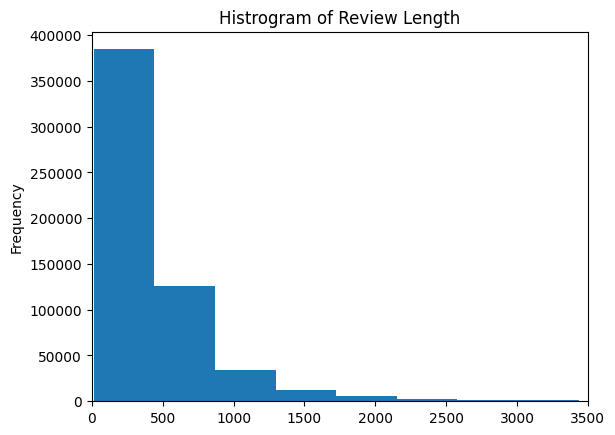

In [7]:
import matplotlib.pyplot as plt

reviews['Text'].str.len().plot(kind='hist', title='Histrogram of Review Length', bins=50)
plt.xlim(0, 3500)

(0.0, 100.0)

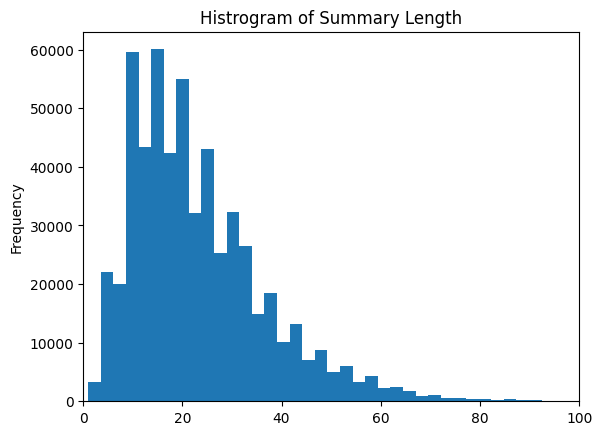

In [8]:

reviews['Summary'].str.len().plot(kind='hist', title='Histrogram of Summary Length', bins=50)
plt.xlim(0, 100)

<Axes: title={'center': 'Histogram of Summary Length'}, ylabel='Frequency'>

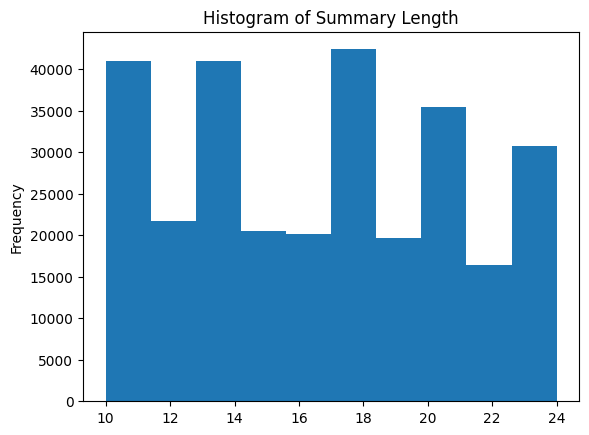

In [9]:
reviews = reviews[(reviews['Summary'].str.len() >= 10) & (reviews['Summary'].str.len() <25)]

reviews['Summary'].str.len().plot(kind='hist', title='Histogram of Summary Length')

In [10]:
reviews['Sentiment'] = reviews['Score'].apply(lambda x: 'positive' if x >= 4 else 'neutral' if x >= 3 else 'negetive')

reviews = reviews.groupby('Sentiment', group_keys=False).apply(lambda x: x.sample(1000))

<ipython-input-10-b0b01ef81640>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reviews = reviews.groupby('Sentiment', group_keys=False).apply(lambda x: x.sample(1000))


<Axes: >

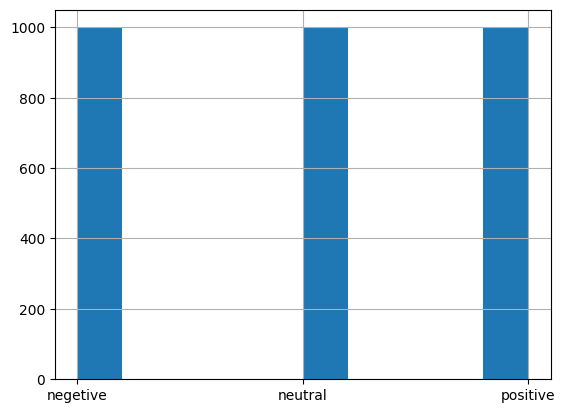

In [11]:
reviews['Sentiment'].hist()

In [22]:
MODEL = 'distilgpt2'
tokenizer = GPT2Tokenizer.from_pretrained(MODEL)
tokenizer.pad_token = tokenizer.eos_token

SENTIMENT_PROMPT = 'Sentiment Task'
SUMMARY_PROMPT = 'Summarize Task'
SENTIMENT_TOKEN = 'Sentiment Task'
SUMMARY_TOKEN = 'Summarize Task'

In [25]:
reviews['sentiment_text'] = f"{SENTIMENT_PROMPT}\n Review: " + reviews['Text'] + SENTIMENT_TOKEN + ': ' + reviews['Sentiment'].astype(str)
reviews['summarization_text'] = f'{SUMMARY_PROMPT}\n Review: ' + reviews['Text'] + SUMMARY_TOKEN + ': ' + reviews['Summary'].astype(str)

In [26]:
reviews['sentiment_text'].head(2).tolist()

['Sentiment Task\n Review: Got BabyBrezza 5 month ago. Nice for steaming, but blending never worked properly. Here is why:<br />1. When you steam the food a lot of water gets accumulated in the food container - too much, so before I blend I have to get some water out. The instructions said that you can get water in the food container if you put too much water in the water chamber - this not true, I tried everything and no matter what there is just too much water in the food container.<br />2. The food is not blended enough to be as smooth as the babies prefer there food, so I ended up blending the steamed food in the blender. And, there are always a couple of chunky peaces in the bottom of the container after blending. Fine, I could use the blending function on a later stage, I thought. But...<br />3. After 4 month of use (mostly for steaming), the blending function is not working. The machine makes a loud noise but the blades do not move. Some reviews suggest how to repair this "flaw"

In [27]:
reviews['summarization_text'].head(2).tolist()

['Summarize Task\n Review: Got BabyBrezza 5 month ago. Nice for steaming, but blending never worked properly. Here is why:<br />1. When you steam the food a lot of water gets accumulated in the food container - too much, so before I blend I have to get some water out. The instructions said that you can get water in the food container if you put too much water in the water chamber - this not true, I tried everything and no matter what there is just too much water in the food container.<br />2. The food is not blended enough to be as smooth as the babies prefer there food, so I ended up blending the steamed food in the blender. And, there are always a couple of chunky peaces in the bottom of the container after blending. Fine, I could use the blending function on a later stage, I thought. But...<br />3. After 4 month of use (mostly for steaming), the blending function is not working. The machine makes a loud noise but the blades do not move. Some reviews suggest how to repair this "flaw"

In [28]:
reviews = reviews.sample(frac=1)

training_examples = reviews['summarization_text'].tolist() + reviews['sentiment_text'].tolist()

print(len(training_examples))

6000


In [31]:
multi_task_df = pd.DataFrame({'task': training_examples})

date = Dataset.from_pandas(multi_task_df)

def preprocess(examples):
  return tokenizer(examples['task'], truncation=True)

data = date.map(preprocess, batched=True)

data = data.train_test_split(test_size=0.8)


Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

In [32]:
model = GPT2LMHeadModel.from_pretrained(MODEL)

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [34]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [35]:
training_args = TrainingArguments(
  output_dir='./gpt2-multitask',
  overwrite_output_dir=True,
  num_train_epochs=2,
  per_device_train_batch_size=32,
  per_device_eval_batch_size=32,
  evaluation_strategy='epoch',
  save_strategy='epoch',
  logging_steps=50
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=data['train'],
    eval_dataset=data['test']
)

trainer.evaluate()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
trainer.train()

In [ ]:
trainer.save_model()

In [ ]:
loaded_model = GPT2LMHeadModel.from_pretrained('./gpt2-multitask')
generator = pipeline('text-generation', model=loaded_model, tokenizer=tokenizer)